In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler

## Audio exploration

In [2]:
file_path = "/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/flickr_audio/wavs/667626_18933d713e_0.wav"
y, sr = librosa.load(file_path)

In [3]:
sr, y[0].shape

(22050, ())

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

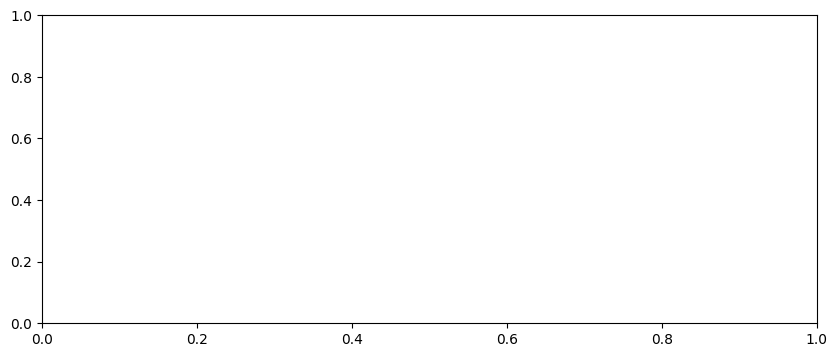

In [4]:
plt.figure(figsize=(10, 4))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [5]:
ipd.Audio(y, rate=sr)

In [6]:
y.shape[0]

56320

In [7]:
sr

22050

In [8]:
scal = StandardScaler()

def add_noise(feature, mean=0, std=0.006):
    noised = feature + np.random.normal(mean, std, feature.shape)
    return noised

def preprocess_audio_mel(y, sr, fixed_length, n_fft=2048, hop_length=512, n_mels=128):
    # Ensure fixed length
    y = librosa.util.fix_length(y, size=fixed_length)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    return mel_spectrogram

def inverse_preprocess_audio_mel(mel_spectrogram, sr, fixed_length, n_fft=2048, hop_length=512, n_iter=32):
    # Invert Mel spectrogram to magnitude spectrogram
    magnitude = np.sqrt(librosa.feature.inverse.mel_to_stft(mel_spectrogram))

    # Reconstruct audio signal using Griffin-Lim algorithm
    y = librosa.griffinlim(magnitude, n_iter=n_iter, hop_length=hop_length)

    # Fix length of the reconstructed audio
    y = librosa.util.fix_length(y, size=fixed_length)

    return y

def preprocess_audio_mfcc(y, sr, fixed_length, n_fft=2048, hop_length=512, n_mfcc=20, n_mels=128):

    # Ensure fixed length
    y = librosa.util.fix_length(y, size=fixed_length)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Compute MFCC features directly from the Mel spectrogram
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel_spectrogram), n_mfcc=n_mfcc)

    # Scale MFCC features
    scaled_mfcc = scal.fit_transform(mfcc)

    return scaled_mfcc

def inverse_preprocess_audio_mfcc(flattened_mfcc, sr, fixed_length, n_mels=128, n_iter=32, hop_length=512):
    # Inverse scale MFCC features
    mfcc = scal.inverse_transform(flattened_mfcc)

    # Convert MFCC to Mel spectrogram
    mel_spectrogram = librosa.feature.inverse.mfcc_to_mel(mfcc, n_mels=n_mels)

    # Invert Mel spectrogram to magnitude spectrogram
    magnitude = np.sqrt(librosa.feature.inverse.mel_to_stft(mel_spectrogram))

    # Reconstruct audio signal using Griffin-Lim algorithm
    y = librosa.griffinlim(magnitude, n_iter=n_iter, hop_length=hop_length)

    # Fix length of the reconstructed audio
    y = librosa.util.fix_length(y, size=fixed_length)

    return y


## Experimenting with different representations

In [9]:
noisy_y = add_noise(y)
mel = preprocess_audio_mel(y, sr, y.shape[0])
noisy_mel = add_noise(np.array(mel))
mfcc = preprocess_audio_mfcc(y, sr, y.shape[0])
noisy_mfcc = add_noise(np.array(mfcc))

In [10]:
y.shape,noisy_y.shape, noisy_mel.shape, mfcc.shape, noisy_mfcc.shape

((56320,), (56320,), (128, 111), (20, 111), (20, 111))

In [11]:
ipd.Audio(noisy_y, rate=sr)

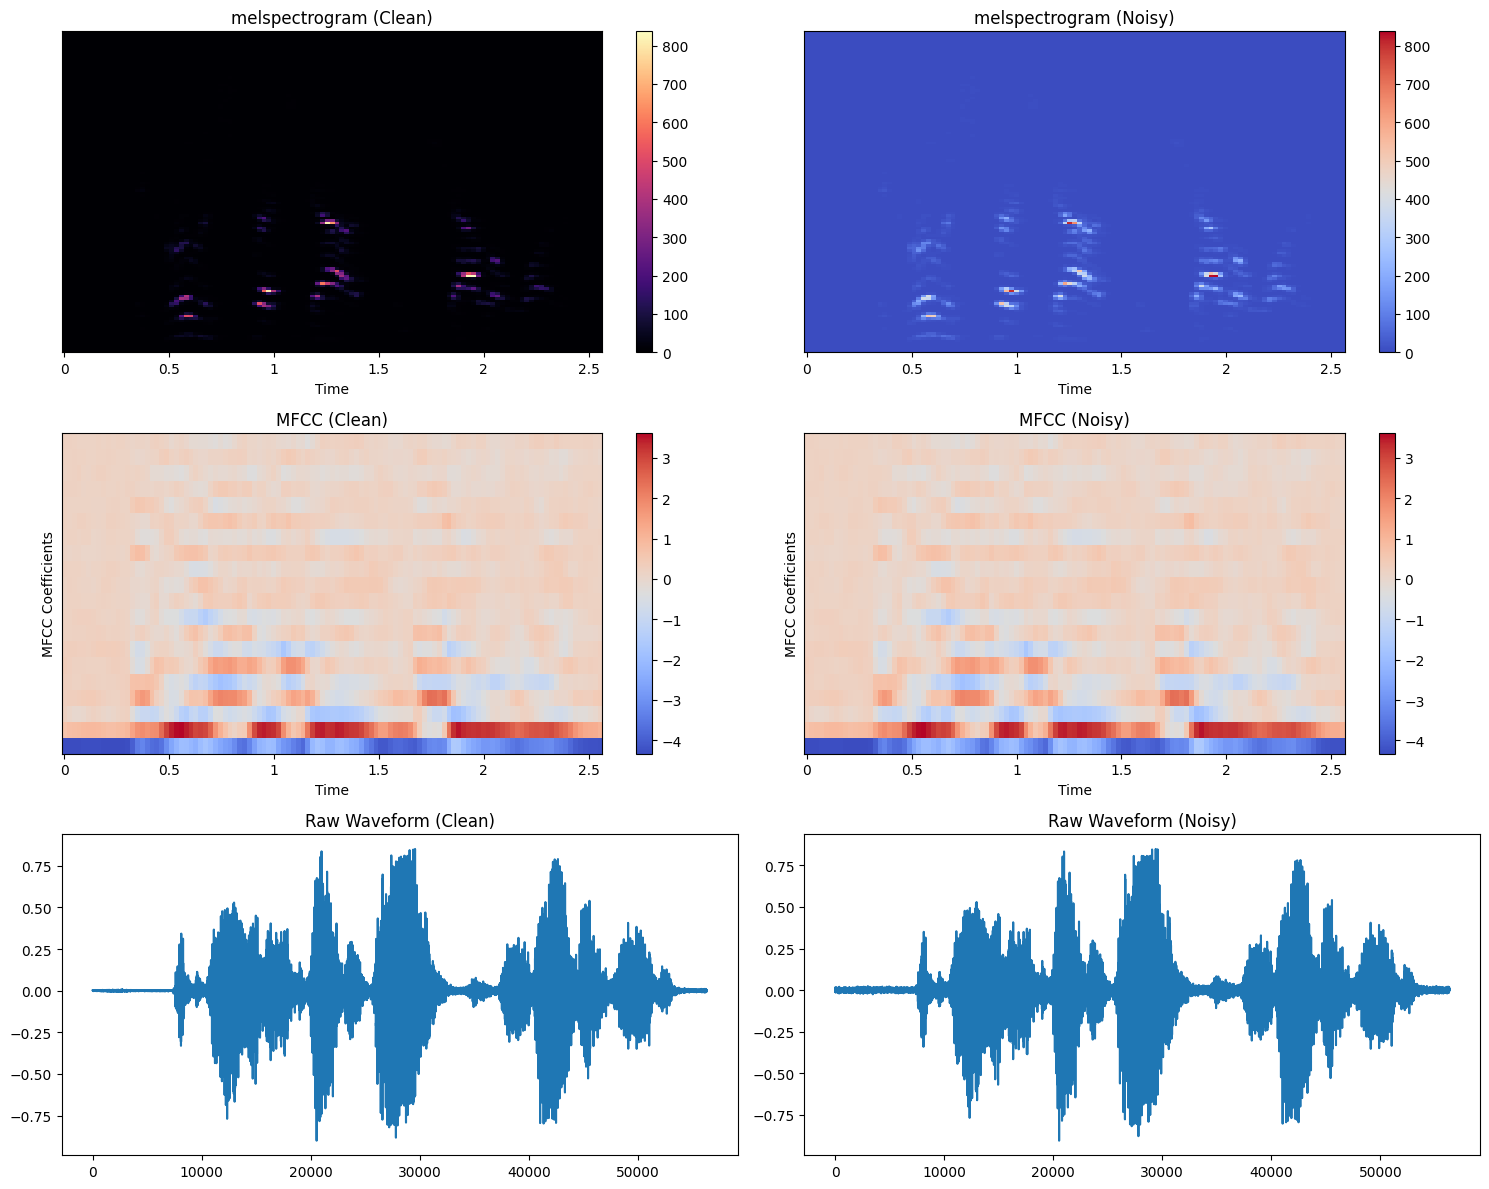

In [12]:
plt.figure(figsize=(15, 12))

# Raw waveform
plt.subplot(3, 2, 5)
plt.plot(y)
plt.title('Raw Waveform (Clean)')

plt.subplot(3, 2, 6)
plt.plot(noisy_y)
plt.title('Raw Waveform (Noisy)')

# melspectrogram
plt.subplot(3, 2, 1)
librosa.display.specshow(mel, x_axis='time')
plt.colorbar()
plt.title('melspectrogram (Clean)')

plt.subplot(3, 2, 2)
librosa.display.specshow(noisy_mel, x_axis='time')
plt.colorbar()
plt.title('melspectrogram (Noisy)')

# MFCC
plt.subplot(3, 2, 3)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC (Clean)')
plt.ylabel('MFCC Coefficients')

plt.subplot(3, 2, 4)
librosa.display.specshow(noisy_mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC (Noisy)')
plt.ylabel('MFCC Coefficients')

plt.tight_layout()
plt.show()

### Experimenting reconstruction of audio from different representations

#### Clean

In [13]:
y_reconstructed_mel = inverse_preprocess_audio_mel(mel, sr, y.shape[0])
y_reconstructed_mfcc = inverse_preprocess_audio_mfcc(mfcc, sr, y.shape[0])
y_reconstructed_mel.shape, y_reconstructed_mfcc.shape, y.shape

((56320,), (56320,), (56320,))

In [14]:
ipd.Audio(y_reconstructed_mel, rate=sr)

In [15]:
ipd.Audio(y_reconstructed_mfcc, rate=sr)

In [16]:
ipd.Audio(y, rate=sr)

#### Noisy

In [17]:
noisy_y_reconstructed_mel = inverse_preprocess_audio_mel(noisy_mel, sr, y.shape[0])
noisy_y_reconstructed_mfcc = inverse_preprocess_audio_mfcc(noisy_mfcc, sr, y.shape[0])
noisy_y_reconstructed_mel.shape, noisy_y_reconstructed_mfcc.shape, noisy_y.shape

((56320,), (56320,), (56320,))

In [18]:
ipd.Audio(noisy_y_reconstructed_mel, rate=sr)

In [19]:
ipd.Audio(noisy_y_reconstructed_mfcc, rate=sr)

In [20]:
ipd.Audio(noisy_y, rate=sr)

## Hybrid Representation

In [21]:
y.shape ,mel.shape, mfcc.shape

((56320,), (128, 111), (20, 111))

In [22]:
# Concatenate Mel spectrogram and MFCC representations along the feature dimension
hybrid_representation_clean = np.concatenate((mel, mfcc), axis=0)
hybrid_representation_noisy = np.concatenate((noisy_mel, noisy_mfcc), axis=0)

# Check the shape of hybrid representations
hybrid_representation_clean.shape, hybrid_representation_noisy.shape

((148, 111), (148, 111))

#### Reconstruction from hybrid representation

In [23]:
def reconstruct_audio(hybrid_representation, sr, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=20):
    # Reshape hybrid representation to match original Mel spectrogram and MFCC shapes
    mel_reconstructed = hybrid_representation[:n_mels, :]
    mfcc_reconstructed = hybrid_representation[n_mels:, :]

    # Invert MFCC to obtain MFCC features
    mfcc_reconstructed = scal.inverse_transform(mfcc_reconstructed)

    # Invert Mel spectrogram to magnitude spectrogram
    mel_spectrogram_reconstructed = librosa.feature.inverse.mfcc_to_mel(mfcc_reconstructed, n_mels=n_mels)

    # Invert magnitude spectrogram to audio signal
    y_reconstructed_from_mfcc = librosa.feature.inverse.mel_to_audio(mel_spectrogram_reconstructed, sr=sr, hop_length=hop_length)
    
    y_reconstructed_from_mel = librosa.feature.inverse.mel_to_audio(mel_reconstructed, sr=sr, hop_length=hop_length)

    return y_reconstructed_from_mfcc, y_reconstructed_from_mel

# Reconstruct clean and noisy audio
clean_audio_reconstructed_mfcc, clean_audio_reconstructed_mel = reconstruct_audio(hybrid_representation_clean, sr)
noisy_audio_reconstructed_mfcc, noisy_audio_reconstructed_mel = reconstruct_audio(hybrid_representation_noisy, sr)


#### Clean

In [24]:
ipd.Audio(clean_audio_reconstructed_mfcc, rate=sr)

In [25]:
ipd.Audio(clean_audio_reconstructed_mel, rate=sr)

#### Noisy

In [26]:
ipd.Audio(noisy_audio_reconstructed_mfcc, rate=sr)

In [27]:
ipd.Audio(noisy_audio_reconstructed_mel, rate=sr)

### Experimet with one file after preprocessing

In [28]:
hybrid_representation_clean.shape, hybrid_representation_noisy.shape

((148, 111), (148, 111))

-----------------------------------------

# Reconstruction from hybrid representation audio approach

In [29]:
import os
import joblib
## Audio aproach
clean_file_path = os.path.join('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_audio/train/clean_hybrid_representations', '10815824_2997e03d76_4_hybrid_representation_clean.npy')
noisy_file_path = os.path.join('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_audio/train/noisy_hybrid_representations', '10815824_2997e03d76_4_hybrid_representation_noisy.npy')
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_audio/weights/scaler.save')
clean_representation_test = np.load(clean_file_path)
noisy_representation_test = np.load(noisy_file_path)

In [30]:
clean_representation_test.shape, noisy_representation_test.shape

((148, 109), (148, 109))

In [31]:
clean_audio_reconstructed_mfcc_test, clean_audio_reconstructed_mel_test = reconstruct_audio(clean_representation_test, sr)
noisy_audio_reconstructed_mfcc_test, noisy_audio_reconstructed_mel_test = reconstruct_audio(noisy_representation_test, sr)

In [32]:
ipd.Audio(clean_audio_reconstructed_mfcc_test, rate=sr)

In [33]:
ipd.Audio(clean_audio_reconstructed_mel_test, rate=sr)

# Reconstruction from hybrid representation feature approach

In [34]:
## Feature aproach
clean_file_path = os.path.join('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_features/train/clean_hybrid_representations', '10815824_2997e03d76_4_hybrid_representation_clean.npy')
noisy_file_path = os.path.join('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_features/train/noisy_hybrid_representations', '10815824_2997e03d76_4_hybrid_representation_noisy.npy')
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_features/weights/scaler.save')
clean_representation_test = np.load(clean_file_path)
noisy_representation_test = np.load(noisy_file_path)

In [35]:
clean_representation_test.shape, noisy_representation_test.shape

((148, 109), (148, 109))

In [36]:
clean_audio_reconstructed_mfcc_test, clean_audio_reconstructed_mel_test = reconstruct_audio(clean_representation_test, sr)
noisy_audio_reconstructed_mfcc_test, noisy_audio_reconstructed_mel_test = reconstruct_audio(noisy_representation_test, sr)

In [37]:
ipd.Audio(clean_audio_reconstructed_mfcc_test, rate=sr)

In [38]:
ipd.Audio(clean_audio_reconstructed_mel_test, rate=sr)

------------------------ 

From array

In [39]:
import os
import joblib
## Audio aproach
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_audio/weights/scaler.save')
clean_representation_test = np.load('data/noise_on_audio/processed_data/train/clean_hybrid_representations.npy')
noisy_representation_test = np.load('data/noise_on_audio/processed_data/train/noisy_hybrid_representations.npy')

In [40]:
clean_representation_test.shape, noisy_representation_test.shape

# Aplicar la función a la primera posición de clean_representation_test
clean_audio_reconstructed_mfcc_test, clean_audio_reconstructed_mel_test = reconstruct_audio(clean_representation_test[2000], sr)

# Aplicar la función a la primera posición de noisy_representation_test
noisy_audio_reconstructed_mfcc_test, noisy_audio_reconstructed_mel_test = reconstruct_audio(noisy_representation_test[2000], sr)

clean_representation_test[0].shape

(148, 109)

In [41]:
ipd.Audio(clean_audio_reconstructed_mfcc_test, rate=sr)

In [42]:
ipd.Audio(clean_audio_reconstructed_mel_test, rate=sr)

In [43]:
ipd.Audio(noisy_audio_reconstructed_mfcc_test, rate=sr)

In [44]:
ipd.Audio(noisy_audio_reconstructed_mel_test, rate=sr)

from array

In [45]:
import os
import joblib
## Feature aproach
scal = joblib.load('/mnt/c/Users/rafaj/Documents/datasets/audio-denoising-auto-encoder/data/processed_data/noisy_features/weights/scaler.save')
clean_representation_test = np.load('data/noise_on_features/processed_data/train/clean_hybrid_representations.npy')
noisy_representation_test = np.load('data/noise_on_features/processed_data/train/noisy_hybrid_representations.npy')


In [46]:
clean_representation_test.shape, noisy_representation_test.shape

((36000, 148, 109), (36000, 148, 109))

In [ ]:
clean_audio_reconstructed_mfcc_test, clean_audio_reconstructed_mel_test = reconstruct_audio(clean_representation_test[2000], sr)
noisy_audio_reconstructed_mfcc_test, noisy_audio_reconstructed_mel_test = reconstruct_audio(noisy_representation_test[2000], sr)

In [ ]:
ipd.Audio(clean_audio_reconstructed_mfcc_test, rate=sr)

In [ ]:
ipd.Audio(clean_audio_reconstructed_mel_test, rate=sr)

In [ ]:
ipd.Audio(noisy_audio_reconstructed_mfcc_test, rate=sr)

In [ ]:
ipd.Audio(noisy_audio_reconstructed_mel_test, rate=sr)